# Distributed PyTorch Image Classification
# Tutorial

**Learning Objectives** - By the end of this tutorial you should be able to use Azure Machine Learning (AzureML) to:
- quickly implement basic commands for data preparation
- test and run a multi-node multi-gpu pytorch job
- use mlflow to analyze your metrics

**Requirements** - In order to benefit from this tutorial, you need:
- to have provisioned an AzureML workspace
- to have permissions to provision a minimal cpu and gpu cluster or simply use [serverless compute (preview)](https://learn.microsoft.com/azure/machine-learning/how-to-use-serverless-compute?view=azureml-api-2&tabs=python)
- to have [installed Azure Machine Learning Python SDK v2](https://github.com/Azure/azureml-examples/blob/sdk-preview/sdk/README.md)

**Motivations** - Let's consider the following scenario: we want to explore training different image classifiers on distinct kinds of problems, based on a large public dataset that is available at a given url. This ML pipeline will be future-looking, in particular we want:
- **genericity**: to be fairly independent from the data we're ingesting (so that we could switch to internal proprietary data in the future),
- **configurability**: to run different versions of that training with simple configuration changes,
- **scalability**: to iterate on the pipeline on small sample, then smoothly transition to running at scale.


### Connect to AzureML

Before we dive in the code, we'll need to create an instance of MLClient to connect to Azure ML.

We are using `DefaultAzureCredential` to get access to workspace. `DefaultAzureCredential` should be capable of handling most Azure SDK authentication scenarios.

Reference for more available credentials if it does not work for you: [configure credential example](https://github.com/Azure/azureml-examples/blob/sdk-preview/sdk/jobs/configuration.ipynb), [azure-identity reference doc](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity?view=azure-python).

In [1]:
# authentication package
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [2]:
# handle to the workspace
from azure.ai.ml import MLClient

# get a handle to the workspace
ml_client = MLClient(
    subscription_id="0ac7b36f-d0da-40e1-9e2a-3644bc3c6d6f",
    resource_group_name="dips-ml-studio",
    workspace_name="dips-ml-workspace",
    credential=credential,
)

cpu_cluster = None
gpu_cluster = None

### Provision the required resources for this notebook (Optional)

We'll need 2 clusters for this notebook, a CPU cluster and a GPU cluster. First, let's create a minimal cpu cluster.

In [3]:
from azure.ai.ml.entities import AmlCompute

cpu_compute_target = "cpu-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        # Name assigned to the compute cluster
        name="cpu-cluster",
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_DS3_V2",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=4,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.begin_create_or_update(cpu_cluster).result()

print(
    f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}"
)

ActivityCompleted: Activity=Compute.Get, HowEnded=Failure, Duration=883.9 [ms], Exception=ResourceNotFoundError, ErrorCategory=UserError, ErrorMessage=Operation returned an invalid status 'Not Found'


Creating a new cpu compute target...
AMLCompute with name cpu-cluster is created, the compute size is STANDARD_DS3_V2


For GPUs, we're creating the cluster below with the smallest VM family.

In [4]:
from azure.ai.ml.entities import AmlCompute

# GPU cluster creation is skipped due to subscription quota limitations
# The training job will automatically use serverless compute instead
# To enable GPU cluster creation, uncomment the code below after requesting quota increase

# gpu_compute_target = "gpu-cluster"
# 
# try:
#     # let's see if the compute target already exists
#     gpu_cluster = ml_client.compute.get(gpu_compute_target)
#     print(
#         f"You already have a cluster named {gpu_compute_target}, we'll reuse it as is."
#     )
# 
# except Exception:
#     print("Creating a new gpu compute target...")
# 
#     gpu_cluster = AmlCompute(
#         name="gpu-cluster",
#         type="amlcompute",
#         size="STANDARD_NC6s_v3",  # 1 x NVIDIA Tesla V100
#         min_instances=0,
#         max_instances=4,
#         idle_time_before_scale_down=180,
#         tier="Dedicated",
#     )
# 
#     gpu_cluster = ml_client.begin_create_or_update(gpu_cluster).result()

print("Using serverless compute for GPU training (no pre-allocated cluster needed)")
print("This avoids quota limitations and auto-scales based on job requirements")

Using serverless compute for GPU training (no pre-allocated cluster needed)
This avoids quota limitations and auto-scales based on job requirements


# 1. Unpack a public image archives with a simple command (no code)

To train our classifier, we'll consume the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) or the [Places2 dataset](http://places2.csail.mit.edu/download.html). If we were to use this locally, the sequence would be very basic: download a large tar archive, untar and put in different train/validation folders, upload to the cloud for consumption by the training script.

We'll do just that, but in the cloud, without too much pain.

## 1.1. Unpack a first small dataset for testing

The Azure ML SDK provides `entities` to implement any step of a workflow. In the example below, we create a `CommandJob` with just a shell command. We parameterize this command by using a string template syntax provided by the SDK:

> ```
> tar xvfm ${{inputs.archive}} --no-same-owner -C ${{outputs.images}}
> ```

Creating the component just consists in declaring the names of the inputs, outputs, and specifying an environment. For this simple job we'll use a curated environment from AzureML. After that, we'll be able to reuse that component multiple times in our pipeline design.

Note: in this job, we're using an input type `uri_file` with a direct url. In this case, Azure ML will download the file from the url and provide it for the job to execute.

In [4]:
from azure.ai.ml import command
from azure.ai.ml import Input, Output
from azure.ai.ml.constants import AssetTypes

dogs_dataset_command_job = command(
    display_name="untar_dogs",  # optional: this will show in the UI
    # this component has no code, just a simple unzip command
    command="tar xvfm ${{inputs.archive}} --no-same-owner -C ${{outputs.images}}",
    # I/O specifications, each using a specific key and type
    inputs={
        "archive": Input(
            type=AssetTypes.URI_FILE,
            path="http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar",
        )
    },
    outputs={
        # two outputs, used in command as outputs.*
        "images": Output(
            type=AssetTypes.URI_FOLDER,
            mode="upload",
            path="azureml://datastores/workspaceblobstore/paths/tutorial-datasets/dogs/",
        ),
    },
    # we're using a curated environment
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu:1",
    compute="cpu-cluster"
    if (cpu_cluster)
    else None,  # No compute needs to be passed to use serverless
)

In [5]:
import webbrowser

# submit the command
returned_job = ml_client.create_or_update(
    dogs_dataset_command_job,
)

# get a URL for the status of the job
print("The url to see your live job running is returned by the sdk:")
print(returned_job.studio_url)
# open the browser with this url
webbrowser.open(returned_job.studio_url)

# print the pipeline run id
print(
    f"The pipeline details can be access programmatically using identifier: {returned_job.name}"
)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
pathOnCompute is not a known attribute

The url to see your live job running is returned by the sdk:
https://ml.azure.com/runs/crimson_soursop_f5kms842r1?wsid=/subscriptions/0ac7b36f-d0da-40e1-9e2a-3644bc3c6d6f/resourcegroups/dips-ml-studio/workspaces/dips-ml-workspace&tid=af8819b1-93b7-4fea-9207-fec6fcaeeb5a
The pipeline details can be access programmatically using identifier: crimson_soursop_f5kms842r1


## 1.2. Unpack a second larger dataset for training [optional]

If you'd like to test the distributed training job below with a more complex dataset, the code below will unpack the [Places2 dataset](http://places2.csail.mit.edu/download.html) dataset images, which has 1.8 million images in 365 categories. This will require a larger VM than the one you provisioned earlier. We recommend you provision a [STANDARD_DS12_V2](https://docs.microsoft.com/en-us/azure/virtual-machines/dv2-dsv2-series-memory). The code below will use compute cluster name `cpu-cluster-lg`.

```python
from azure.ai.ml import command
from azure.ai.ml import Input, Output
from azure.ai.ml.constants import AssetTypes

places2_command_job = command(
    display_name="untar_places2",  # optional: this will show in the UI
    # this component has no code, just a simple unzip command
    command="&&\n".join(
        [
            # two lines of commands, one for training, one for validation
            "tar xvfm ${{inputs.archive}} --no-same-owner -C ${{outputs.valid_images}} places365_standard/val/",
            "tar xvfm ${{inputs.archive}} --no-same-owner -C ${{outputs.train_images}} places365_standard/train/",
        ]
    ),
    # I/O specifications, each using a specific key and type
    inputs={
        "archive": Input(
            type=AssetTypes.URI_FILE,
            path="http://data.csail.mit.edu/places/places365/places365standard_easyformat.tar",
        )
    },
    outputs={
        # two outputs, used in command as outputs.*
        "train_images": Output(
            type=AssetTypes.URI_FOLDER,
            mode="upload",
            path="azureml://datastores/workspaceblobstore/paths/tutorial-datasets/places2/train/"
        ),
        "valid_images": Output(
            type=AssetTypes.URI_FOLDER,
            mode="upload",
            path="azureml://datastores/workspaceblobstore/paths/tutorial-datasets/places2/valid/"
        ),
    },
    # we're using a curated environment
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu:1",
    compute="cpu-cluster-lg",
)

# submit the command
returned_job = ml_client.create_or_update(places2_command_job)

# get a URL for the status of the job
print("The url to see your live job running is returned by the sdk:")
print(returned_job.studio_url)
```


# 2. Training a distributed gpu job

Implementing a distributed pytorch training is complex. Of course in this tutorial we've written one for you, but the point is: it takes time, it takes several iterations, each requiring you to try your code locally, then in the cloud, then try it at scale, until satisfied and then run a full blown production model training. This trial/error process can be made easier if we can create reusable code we can iterate on quickly, and that can be configured to run from small to large scale.

So, to develop our training pipeline, we set a couple constraints for ourselves:
- we want to minimize the effort to iterate on the pipeline code when porting it in the cloud,
- we want to use the same code for small scale and large scale testing
- we do not want to manipulate large data locally (ex: download/upload that data could take multiple hours),

We've implemented a distributed pytorch training script that we can load as a command job. For this, we've decided to parameterize this job with relevant training arguments (see below).

We can now test this code by running it on a smaller dataset in Azure ML. Here, we will use the dogs dataset both for training and validation. Of course, the model will not be valid. But training will be short (8 mins on 2 x STANDARD_NC6 for 1 epoch) to allow us to iterate if needed.


In [6]:
from azure.ai.ml import command
from azure.ai.ml import Input

training_job = command(
    # local path where the code is stored
    code="./src/pytorch_dl_train/",
    # describe the command to run the python script, with all its parameters
    # use the syntax below to inject parameter values from code
    command="""python train.py \
        --train_images ${{inputs.train_images}} \
        --valid_images ${{inputs.valid_images}} \
        --batch_size ${{inputs.batch_size}} \
        --num_workers ${{inputs.num_workers}} \
        --prefetch_factor ${{inputs.prefetch_factor}} \
        --model_arch ${{inputs.model_arch}} \
        --model_arch_pretrained ${{inputs.model_arch_pretrained}} \
        --num_epochs ${{inputs.num_epochs}} \
        --learning_rate ${{inputs.learning_rate}} \
        --momentum ${{inputs.momentum}} \
        --register_model_as ${{inputs.register_model_as}} \
        --enable_profiling ${{inputs.enable_profiling}}
    """,
    inputs={
        "train_images": Input(
            type="uri_folder",
            path="azureml://datastores/workspaceblobstore/paths/tutorial-datasets/dogs/",
            # path="azureml://datastores/workspaceblobstore/paths/tutorial-datasets/places2/train/",
            mode="download",  # use download to make access faster, mount if dataset is larger than VM
        ),
        "valid_images": Input(
            type="uri_folder",
            path="azureml://datastores/workspaceblobstore/paths/tutorial-datasets/dogs/",
            # path="azureml://datastores/workspaceblobstore/paths/tutorial-datasets/places2/valid/",
            mode="download",  # use download to make access faster, mount if dataset is larger than VM
        ),
        "batch_size": 64,
        "num_workers": 5,  # number of cpus for pre-fetching
        "prefetch_factor": 2,  # number of batches fetched in advance
        "model_arch": "resnet18",
        "model_arch_pretrained": True,
        "num_epochs": 1,
        "learning_rate": 0.01,
        "momentum": 0.01,
        "register_model_as": "dogs_dev",
        # "register_model_as": "places_dev",
        "enable_profiling": False,
    },
    environment="AzureML-pytorch-1.10-ubuntu18.04-py38-cuda11-gpu@latest",
    compute="cpu-cluster",
    instance_count=1,
    display_name="pytorch_training_sample_cpu",
    description="training a torchvision model on CPU (no quota needed)",
)

Once we create that job, we submit it through `MLClient`.

In [7]:
import webbrowser

# submit the job
returned_job = ml_client.jobs.create_or_update(
    training_job,
    # Project's name
    experiment_name="e2e_image_sample",
)

# get a URL for the status of the job
print("The url to see your live job running is returned by the sdk:")
print(returned_job.studio_url)
# open the browser with this url
webbrowser.open(returned_job.studio_url)

# print the pipeline run id
print(
    f"The pipeline details can be access programmatically using identifier: {returned_job.name}"
)
# saving it for later in this notebook
small_scale_run_id = returned_job.name

Uploading pytorch_dl_train (0.04 MBs): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36710/36710 [00:00<00:00, 106264.86it/s]


The url to see your live job running is returned by the sdk:
https://ml.azure.com/runs/gentle_milk_9f1v9kjypx?wsid=/subscriptions/0ac7b36f-d0da-40e1-9e2a-3644bc3c6d6f/resourcegroups/dips-ml-studio/workspaces/dips-ml-workspace&tid=af8819b1-93b7-4fea-9207-fec6fcaeeb5a
The pipeline details can be access programmatically using identifier: gentle_milk_9f1v9kjypx


You can iterate on this design as much as you'd like, updating the local code of the job and re-submit the pipeline.

Note: in the code above, we have commented out the lines you'd need to test this training job on the Places 2 dataset (1.8m images).

# 3. Analyze experiments using MLFlow

Azure ML natively integrates with MLFlow so that if your code already supports MLFlow logging, you will not have to modify it to report your metrics within Azure ML. The component above is using MLFlow internally to report relevant metrics, logs and artifacts. Look for `mlflow` calls within the script `train.py`.

To access this data in the Azure ML Studio, click on the component in the pipeline to open the Details panel, then choose the **Metrics** panel.

You can also access those metrics programmatically using mlflow. We'll demo a couple examples below.

## 3.1. Connect to Azure ML using MLFlow client

Connecting to Azure ML using MLFlow required to `pip install azureml-mlflow mlflow` (both). You can use the `MLClient` to obtain a tracking uri to connect with the mlflow client. In the example below, we'll get all the runs related to the training experiment:

In [8]:
import mlflow
from mlflow.tracking import MlflowClient
import matplotlib.pyplot as plt

mlflow.set_tracking_uri(ml_client.workspaces.get().mlflow_tracking_uri)

# search for the training step within the pipeline
mlflow.set_experiment("e2e_image_sample")

# search for all runs and return as a pandas dataframe
mlflow_runs = mlflow.search_runs()

# display all runs as a dataframe in the notebook
mlflow_runs

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (3.1.1) and mlflow-skinny (2.22.1) are different. This may lead to unexpected behavior. Please install the same version of both packages.
  mlflow.mismatch._check_version_mismatch()


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.epoch_train_loss,metrics.epoch_valid_acc,metrics.epoch_valid_loss,metrics.epoch_train_acc,...,params.cuda_device_count,params.num_epochs,params.learning_rate,params.num_workers,params.model_arch_pretrained,params.distributed_backend,tags.mlflow.runName,tags.mlflow.note.content,tags.mlflow.rootRunId,tags.mlflow.user
0,gentle_milk_9f1v9kjypx,ae826182-f10b-46be-8c90-197756e1159f,FINISHED,,2025-11-14 14:59:27.569000+00:00,2025-11-14 15:43:31.432000+00:00,3.590557,0.033722,4.963666,0.27104,...,0,1,0.01,5,1,nccl,pytorch_training_sample_cpu,training a torchvision model on CPU (no quota ...,gentle_milk_9f1v9kjypx,Dipu Manandhar


## 3.2. Analyze metrics accross multiple jobs

You can also use mlflow to search all your runs, filter by some specific properties and get the results as a pandas dataframe. Once you get that dataframe, you can implement any analysis on top of it.

Below, we're extracting all runs and show the effect of profiling on the epoch training time.

![mlflow runs in a pandas dataframe](./media/pytorch_train_mlflow_runs.png)

In [9]:
runs = mlflow.search_runs(
    # we're using mlflow syntax to restrict to a specific parameter
    filter_string=f"params.model_arch = 'resnet18'"
)

# we're keeping only some relevant columns
columns = [
    "run_id",
    "status",
    "end_time",
    "metrics.epoch_train_time",
    "metrics.epoch_train_acc",
    "metrics.epoch_valid_acc",
    "params.enable_profiling",
]

# showing the raw results in notebook
runs[columns].dropna()

,run_id,status,end_time,metrics.epoch_train_time,metrics.epoch_train_acc,metrics.epoch_valid_acc,params.enable_profiling
0,gentle_milk_9f1v9kjypx,FINISHED,2025-11-14 15:43:31.432000+00:00,1205.232823,0.27104,0.033722,0


## 3.3. Analyze the metrics of a specific job

Using MLFlow, you can retrieve all the metrics produces by a given run. You can then leverage any usual tool to draw the analysis that is relevant for you. In the example below, we're plotting accuracy per epoch.

![plot training and validation accuracy over epochs](./media/pytorch_train_mlflow_plot.png)

Obtaining results for run id gentle_milk_9f1v9kjypx


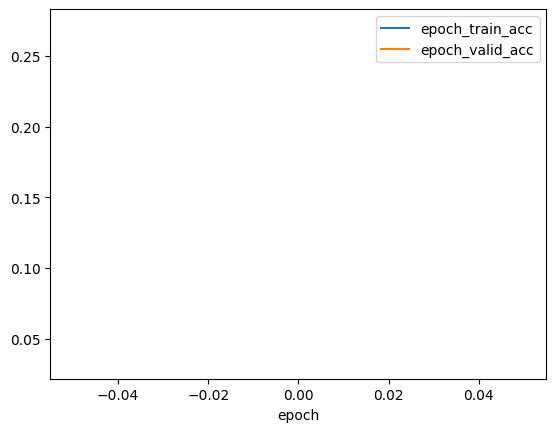

In [10]:
# here we're using the small scale training on validation data
training_run_id = small_scale_run_id

# alternatively, you can directly use a known training step id
# training_run_id = "..."

# open a client to get metric history
client = MlflowClient()

print(f"Obtaining results for run id {training_run_id}")

# create a plot
plt.rcdefaults()
fig, ax = plt.subplots()
ax.set_xlabel("epoch")

for metric in ["epoch_train_acc", "epoch_valid_acc"]:
    # get all values taken by the metric
    try:
        metric_history = client.get_metric_history(training_run_id, metric)
    except:
        print(f"Metric {metric} could not be found in history")
        continue

    epochs = [metric_entry.step for metric_entry in metric_history]
    metric_array = [metric_entry.value for metric_entry in metric_history]
    ax.plot(epochs, metric_array, label=metric)

plt.legend()

## 3.4. Retrieve artifacts for local analysis (ex: tensorboard)

MLFlow also allows you to record artifacts during training. The script `train.py` leverages the [PyTorch profiler](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html) to produce logs for analyzing GPU performance. It uses mlflow to record those logs as artifacts.

To benefit from that, use the option `enable_profiling=True` in the submission code of section 2.

In the following, we'll download those locally to inspect with other tools such as tensorboard.

In [11]:
import os

# here we're using the small scale training on validation data
training_run_id = small_scale_run_id

# alternatively, you can directly use a known training step id
# training_run_id = "..."

# open a client to get metric history
client = MlflowClient()

# create local directory to store artefacts
os.makedirs("./logs/", exist_ok=True)

for artifact in client.list_artifacts(training_run_id, path="profiler/markdown/"):
    print(f"Downloading artifact {artifact.path}")
    client.download_artifacts(training_run_id, path=artifact.path, dst_path="./logs")
else:
    print(f"No artefacts were found for profiler/markdown/ in run id {training_run_id}")

for artifact in client.list_artifacts(
    training_run_id, path="profiler/tensorboard_logs/"
):
    print(f"Downloading artifact {artifact.path}")
    client.download_artifacts(training_run_id, path=artifact.path, dst_path="./logs")
else:
    print(f"No artefacts were found for profiler/markdown/ in run id {training_run_id}")

MlflowException: API request to endpoint /api/2.0/mlflow/logged-models/search failed with error code 404 != 200. Response body: ''

We can now run tensorboard locally with the downloaded artifacts to run some analysis of GPU performance (see example snapshot below).

```
tensorboard --logdir="./logs/profiler/tensorboard_logs/"
```

![tensorboard logs generated by pytorch profiler](./media/pytorch_train_tensorboard_logs.png)

![](media/mlflow_plot.png)